<a href="https://www.kaggle.com/code/femionakunle/regression-of-used-cars?scriptVersionId=198789386" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from sklearn.metrics import mean_squared_error

from xgboost import plot_importance
import re

from datetime import datetime

from sklearn.impute import SimpleImputer

## EDA and Data Preprocessing

In [3]:
df = pd.read_csv('/kaggle/input/playground-series-s4e9/train.csv')
df.head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


In [4]:
dt = pd.read_csv('/kaggle/input/playground-series-s4e9/test.csv')
dt.head(10)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
5,188538,Chevrolet,Express 2500 Work Van,2013,99524,Gasoline,285.0HP 4.8L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
6,188539,Lexus,RX 350 Base,2008,194000,Gasoline,270.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Silver,Gray,None reported,Yes
7,188540,Chevrolet,Impala 1LT,2019,40208,Gasoline,3.8L V6 24V GDI DOHC,6-Speed Automatic,Silver Ice Metallic,Jet Black,None reported,Yes
8,188541,Mercedes-Benz,S-Class S 63 AMG,2016,7600,Gasoline,536.0HP 5.5L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes
9,188542,Genesis,G80 3.3T Sport,2017,63300,Gasoline,365.0HP 3.3L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


## Identify the number of distinct car models/brands in the dataset

In [6]:
print(f"Unique brands: {df['brand'].unique()}\n")
print(f"Total number of brands: {df['brand'].nunique()}")

Unique brands: ['MINI' 'Lincoln' 'Chevrolet' 'Genesis' 'Mercedes-Benz' 'Audi' 'Ford'
 'BMW' 'Tesla' 'Cadillac' 'Land' 'GMC' 'Toyota' 'Hyundai' 'Volvo'
 'Volkswagen' 'Buick' 'Rivian' 'RAM' 'Hummer' 'Alfa' 'INFINITI' 'Jeep'
 'Porsche' 'McLaren' 'Honda' 'Lexus' 'Dodge' 'Nissan' 'Jaguar' 'Acura'
 'Kia' 'Mitsubishi' 'Rolls-Royce' 'Maserati' 'Pontiac' 'Saturn' 'Bentley'
 'Mazda' 'Subaru' 'Ferrari' 'Aston' 'Lamborghini' 'Chrysler' 'Lucid'
 'Lotus' 'Scion' 'smart' 'Karma' 'Plymouth' 'Suzuki' 'FIAT' 'Saab'
 'Bugatti' 'Mercury' 'Polestar' 'Maybach']

Total number of brands: 57


In [7]:
print(f"Unique brands: {dt['brand'].unique()}\n")
print(f"Total number of brands: {dt['brand'].nunique()}")

Unique brands: ['Land' 'Ford' 'Audi' 'Chevrolet' 'Lexus' 'Mercedes-Benz' 'Genesis'
 'Mazda' 'Porsche' 'Jaguar' 'Honda' 'BMW' 'Toyota' 'Hummer' 'RAM' 'Jeep'
 'Cadillac' 'Saturn' 'Kia' 'Lincoln' 'Nissan' 'Volkswagen' 'Chrysler'
 'Dodge' 'Maserati' 'Subaru' 'Hyundai' 'Mitsubishi' 'INFINITI' 'Tesla'
 'Lamborghini' 'MINI' 'GMC' 'Acura' 'Buick' 'Rivian' 'Pontiac' 'Alfa'
 'Mercury' 'Volvo' 'Rolls-Royce' 'McLaren' 'Bentley' 'Aston' 'FIAT'
 'Scion' 'Ferrari' 'Lucid' 'Saab' 'Maybach' 'Karma' 'Suzuki' 'Lotus'
 'Bugatti' 'Plymouth']

Total number of brands: 55


In [8]:
df['accident'].value_counts()

accident
None reported                             144514
At least 1 accident or damage reported     41567
Name: count, dtype: int64

In [9]:
print(f"Training: {df['clean_title'].unique()}")
print(f"Test: {dt['clean_title'].unique()}")

Training: ['Yes' nan]
Test: ['Yes' nan]


In [10]:
print(f"Unique transmission types: {df['transmission'].unique()}\n")
print(f"Total number of unique transmission types: {df['transmission'].nunique()}\n")

Unique transmission types: ['A/T' 'Transmission w/Dual Shift Mode' '7-Speed A/T' '8-Speed A/T'
 '10-Speed Automatic' '1-Speed A/T' '6-Speed A/T' '10-Speed A/T'
 '9-Speed A/T' '8-Speed Automatic' '9-Speed Automatic' '5-Speed A/T'
 'Automatic' '7-Speed Automatic with Auto-Shift' 'CVT Transmission'
 '5-Speed M/T' 'M/T' '6-Speed M/T' '6-Speed Automatic' '4-Speed Automatic'
 '7-Speed M/T' '2-Speed A/T' '1-Speed Automatic' 'Automatic CVT'
 '4-Speed A/T' '6-Speed Manual' 'Transmission Overdrive Switch'
 '8-Speed Automatic with Auto-Shift' '7-Speed Manual' '7-Speed Automatic'
 '9-Speed Automatic with Auto-Shift' '6-Speed Automatic with Auto-Shift'
 '6-Speed Electronically Controlled Automatic with O' 'F' 'CVT-F'
 '8-Speed Manual' 'Manual' '–' '2' '6 Speed At/Mt' '5-Speed Automatic'
 '2-Speed Automatic' '8-SPEED A/T' '7-Speed' 'Variable'
 'Single-Speed Fixed Gear' '8-SPEED AT'
 '10-Speed Automatic with Overdrive' '7-Speed DCT Automatic'
 'SCHEDULED FOR OR IN PRODUCTION' '6-Speed' '6 Speed Mt']


In [11]:
def feature(df):
    df['brand'] = df['brand'].str.lower()
    current_year = datetime.now().year
    df['Vehicle_Age'] = current_year - df['model_year']
    df['Mileage_per_Year'] = df['milage'] / (df['Vehicle_Age'] + 10e-5)
    luxury_brands = ["mercedes-benz","bmw","audi","porsche","lexus","cadillac","jaguar","bentley","genesis","maserati","lamborghini","rolls-royce","ferrari","mclaren","aston","lotus","bugatti","maybach"]
    df['Is_Luxury_Brand'] = df['brand'].apply(lambda x: 1 if x in luxury_brands else 0)
    
    return df

df = feature(df)
dt = feature(dt)

In [12]:
print(f"Engine types: {df['engine'].unique()}\n")
print(f"Number of engine types: {df['engine'].nunique()}")

Engine types: ['172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel'
 '252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel'
 '320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability' ...
 '78.0HP 1.2L 3 Cylinder Engine Gasoline Fuel'
 '139.0HP 1.6L 4 Cylinder Engine Plug-In Electric/Gas'
 '313.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas']

Number of engine types: 1117


In [13]:
print(f"Years: {df['model_year'].unique()}\n")
print(f"Total no of years: {df['model_year'].nunique()}")

Years: [2007 2002 2017 2021 2018 2016 2020 2015 2011 2013 2023 2019 2012 2014
 2008 2009 2022 2003 2005 2001 2006 2000 2010 2004 1997 1998 1999 1994
 1993 1996 1995 2024 1974 1992]

Total no of years: 34


In [14]:
print(f"External colour: {df['ext_col'].unique()}\n")
print(f"Total  number of colours: {df['ext_col'].nunique()}\n")

External colour: ['Yellow' 'Silver' 'Blue' 'Black' 'White' 'Snowflake White Pearl Metallic'
 'Gray' 'Green' 'Santorini Black Metallic' 'Purple'
 'Ebony Twilight Metallic' 'Red' 'Magnetite Black Metallic'
 'Diamond Black' 'Vega Blue' 'Beige' 'Gold' 'Platinum White Pearl'
 'Metallic' 'White Frost Tri-Coat' 'Firecracker Red Clearcoat'
 'Phytonic Blue Metallic' 'Blu' 'Orange' 'Brown'
 'Brilliant Silver Metallic' 'Black Raven' 'Black Clearcoat' 'Firenze Red'
 'Agate Black Metallic' 'Glacial White Pearl' 'Majestic Plum Metallic'
 'designo Diamond White Metallic' 'Oxford White' 'Black Sapphire Metallic'
 'Mythos Black' 'Granite Crystal Clearcoat Metallic'
 'White Diamond Tri-Coat' 'Magnetite Gray Metallic'
 'Carpathian Grey Premium Metallic' 'designo Diamond White Bright'
 'Phantom Black Pearl Effect / Black Roof' 'Nebula Gray Pearl'
 'Deep Crystal Blue Mica' 'Flame Red Clearcoat' 'Lunar Blue Metallic'
 'Bright White Clearcoat' 'Rapid Red Metallic Tinted Clearcoat' 'Caviar'
 'Dark Ash Metalli

## Check for null values in the dataset

In [15]:
print(f"Missing values: {df.isnull().sum()}\n")
print(f"Total number of missing values: {df.isnull().sum().sum()}")
df_mod = df.copy()
dt_mod = dt.copy()

Missing values: id                      0
brand                   0
model                   0
model_year              0
milage                  0
fuel_type            5083
engine                  0
transmission            0
ext_col                 0
int_col                 0
accident             2452
clean_title         21419
price                   0
Vehicle_Age             0
Mileage_per_Year        0
Is_Luxury_Brand         0
dtype: int64

Total number of missing values: 28954


## Check for duplicates

In [16]:
print(f"Total number of duplicates: {df_mod.duplicated().sum()}\n")
#df_mod.drop_duplicates(inplace=True)
# Drop the id column
df_mod_dup = df_mod.copy()
df_mod_dup.drop(['id'], axis=1, inplace=True)
df_mod_dup.head()

Total number of duplicates: 0



,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand
0,mini,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,12529.338063,0
1,lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,6511.334039,0
2,chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,6215.017204,0
3,genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,7,2785.674490,1
4,mercedes-benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,2462.584581,1


## Extract additional features from the engine column

In [17]:
# split the engine column data
def parse_engine_col(text):
    #pattern =  r"(?P<horsepower>\d+\.?\d*)HP\s+(?P<displacement>\d+\.?\d*)L\s+(?P<cylinders>\d+)\sCylinder\sEngine\s+(?P<fuel>.+)\sFuel"
    pattern =  r"(?P<horsepower>\d+\.?\d*)HP\s+(?P<engine_size>\d+\.?\d*)L\s+(?P<cylinders>\d+)\sCylinder\sEngine\s"
    match = re.search(pattern, text)
    if match:
        return pd.Series({
            'horsepower':match.group('horsepower'),
            'engine_size':match.group('engine_size'),
            'cylinders':match.group('cylinders'),
            #'fuel':match.group('fuel')
        })
    else:
        return pd.Series({
            'horsepower':0,
            'engine_size':0,
            'cylinders':0,
            #'fuel':None
        })

In [18]:
# Apply the parsing function to the engine column data and create new columns
df_mod_dup.loc[:,['horsepower', 'engine_size', 'cylinders']] = df_mod_dup['engine'].apply(parse_engine_col)
df_mod_dup.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand,horsepower,engine_size,cylinders
0,mini,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200,17,12529.338063,0,172.0,1.6,4
1,lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999,22,6511.334039,0,252.0,3.9,8
2,chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900,22,6215.017204,0,320.0,5.3,8
3,genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000,7,2785.674490,1,420.0,5.0,8
4,mercedes-benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500,3,2462.584581,1,208.0,2.0,4


## Lets have a look at the distribution of a few features in the dataset

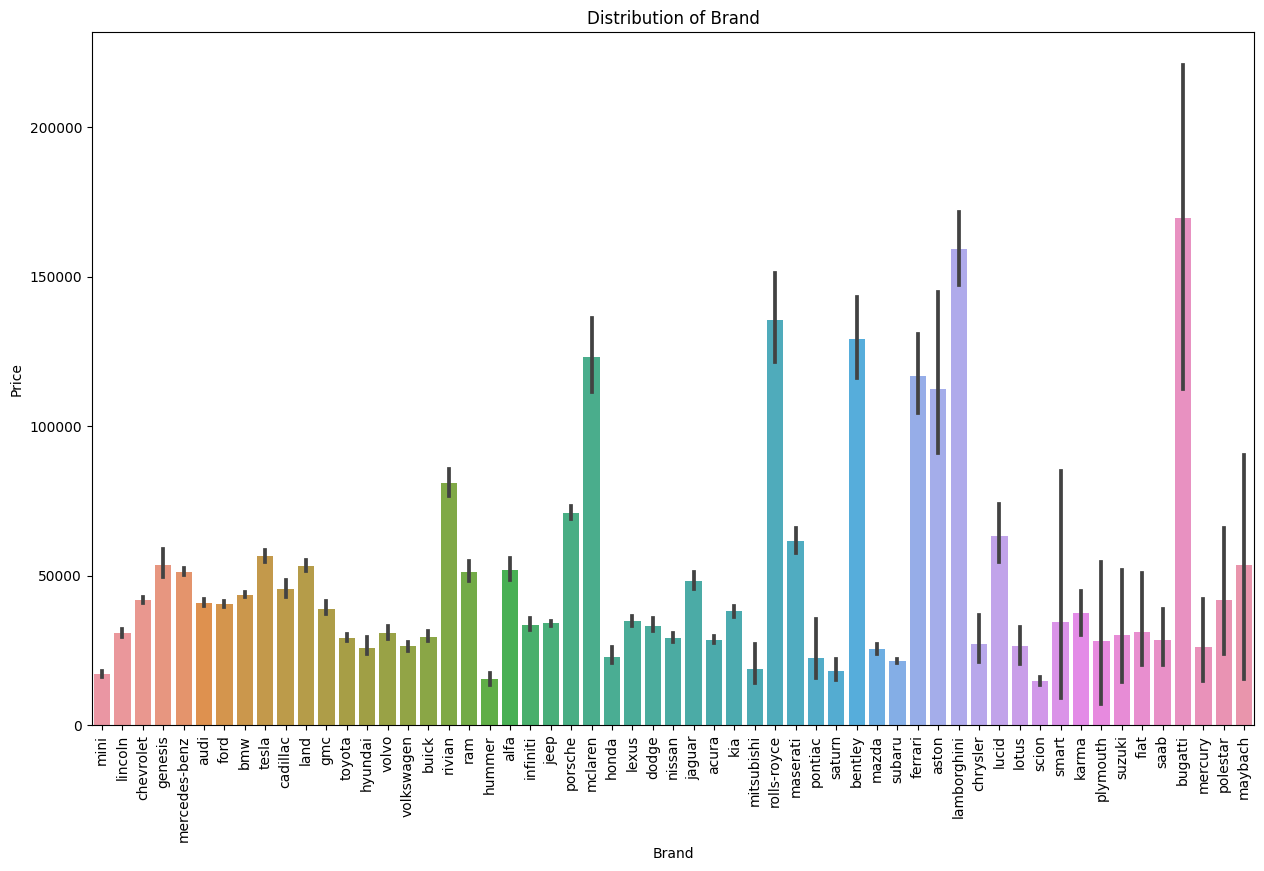

In [19]:
plt.figure(figsize=(15, 9))
sns.barplot(x='brand', y='price', data=df_mod_dup)
plt.xlabel('Brand')
plt.ylabel('Price')
plt.title('Distribution of Brand')
plt.xticks(rotation=90)
plt.show()

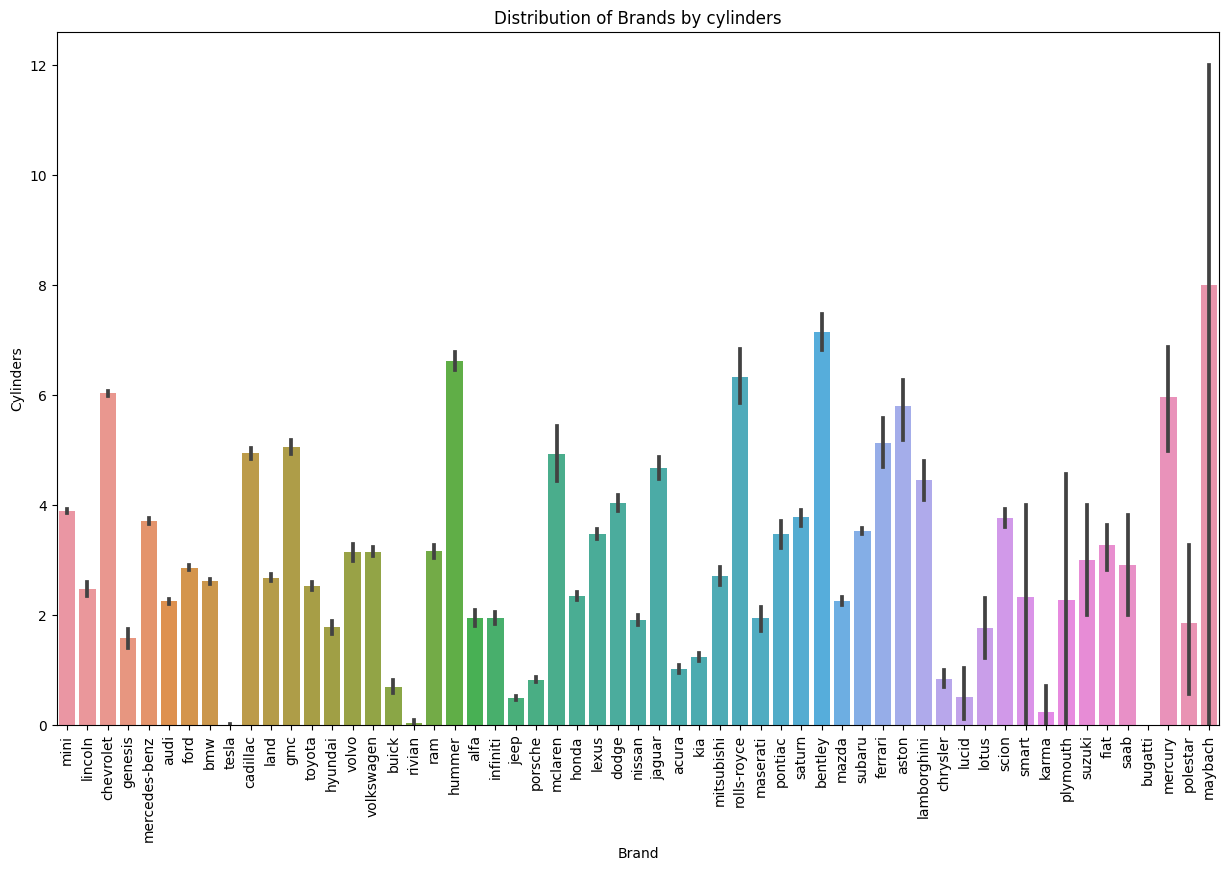

In [20]:
plt.figure(figsize=(15, 9))
sns.barplot(x='brand', y=pd.to_numeric(df_mod_dup['cylinders'], errors='coerce'), data=df_mod_dup)
plt.xlabel('Brand')
plt.ylabel('Cylinders')
plt.title('Distribution of Brands by cylinders')
plt.xticks(rotation=90)
plt.show()

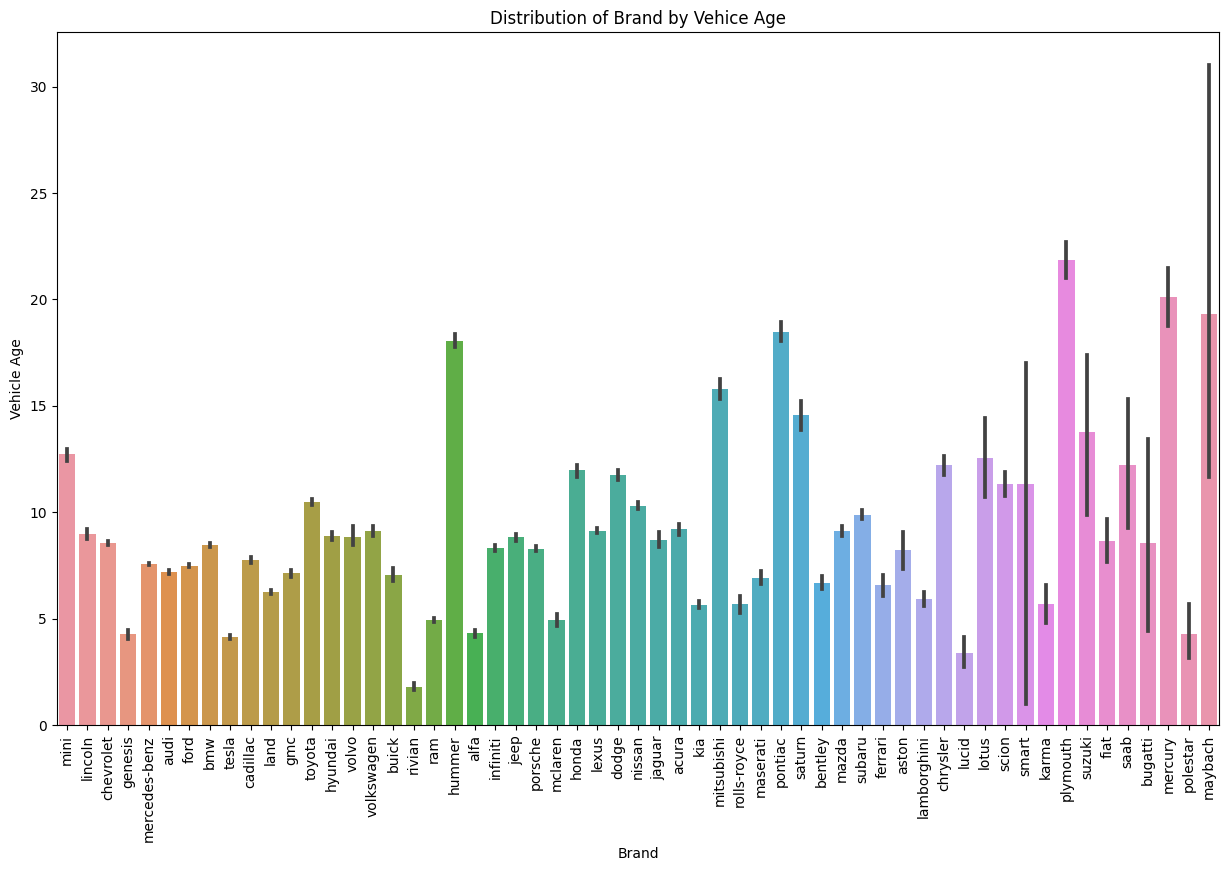

In [21]:
plt.figure(figsize=(15, 9))
sns.barplot(x='brand', y='Vehicle_Age', data=df_mod_dup)
plt.xlabel('Brand')
plt.ylabel('Vehicle Age')
plt.title('Distribution of Brand by Vehice Age')
plt.xticks(rotation=90)
plt.show()

In [22]:
dt_mod.loc[:,['horsepower', 'engine_size', 'cylinders']] = dt_mod['engine'].apply(parse_engine_col)
dt_mod.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand,horsepower,engine_size,cylinders
0,188533,land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,9,10888.767903,0,240.0,2.0,4
1,188534,land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes,4,2285.442864,0,0,0,0
2,188535,ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN,2,14059.797010,0,0,0,0
3,188536,audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN,8,7657.154286,1,0,0,0
4,188537,audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes,6,9833.169447,1,252.0,2.0,4


In [23]:
df_mod_dup.loc[:,'accident'] = df_mod['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1})
dt_mod.loc[:,'accident'] = dt_mod['accident'].map({'None reported': 0, 'At least 1 accident or damage reported': 1})

In [24]:
#drop redundant features
col_drop = ['engine', 'transmission', 'model_year']
df_mod_2 = df_mod_dup.copy()
df_mod_2.drop(col_drop, axis=1, inplace=True)

dt_mod_2 = dt_mod.copy()
dt_mod_2.drop(col_drop, axis=1, inplace=True)
dt_mod_2.head()

,id,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand,horsepower,engine_size,cylinders
0,188533,land,Rover LR2 Base,98000,Gasoline,White,Beige,0.0,Yes,9,10888.767903,0,240.0,2.0,4
1,188534,land,Rover Defender SE,9142,Hybrid,Silver,Black,0.0,Yes,4,2285.442864,0,0,0,0
2,188535,ford,Expedition Limited,28121,Gasoline,White,Ebony,0.0,NaN,2,14059.797010,0,0,0,0
3,188536,audi,A6 2.0T Sport,61258,Gasoline,Silician Yellow,Black,0.0,NaN,8,7657.154286,1,0,0,0
4,188537,audi,A6 2.0T Premium Plus,59000,Gasoline,Gray,Black,0.0,Yes,6,9833.169447,1,252.0,2.0,4


In [25]:
categorical_cols = ['brand', 'model', 'fuel_type', 'ext_col', 'int_col', 'clean_title']
for col in categorical_cols:
    label_encoder = LabelEncoder()
    df_mod_2[col] = label_encoder.fit_transform(df_mod_2[col])
    dt_mod_2[col] = label_encoder.fit_transform(dt_mod_2[col])

df_mod_2.head()

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand,horsepower,engine_size,cylinders
0,37,495,213000,2,312,71,0.0,0,4200,17,12529.338063,0,172.0,1.6,4
1,28,930,143250,2,263,10,1.0,0,4999,22,6511.334039,0,252.0,3.9,8
2,9,1575,136731,1,38,71,0.0,0,13900,22,6215.017204,0,320.0,5.3,8
3,15,758,19500,2,29,14,0.0,0,45000,7,2785.674490,1,420.0,5.0,8
4,35,1077,7388,2,29,10,0.0,0,97500,3,2462.584581,1,208.0,2.0,4


## Lets check for any correlations between some of the features including the target variable.

<Axes: >

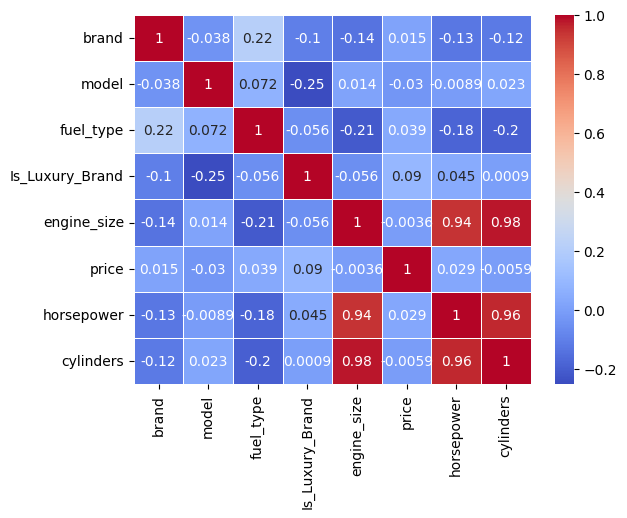

In [26]:
subset_columns = ['brand', 'model', 'fuel_type', 'Is_Luxury_Brand', 'engine_size', 'price', 'horsepower', 'cylinders']
correlation_matrix = df_mod_2[subset_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

In [27]:
# checking the test dataset
print(f"Shape of the dataset: {dt_mod_2.shape}")
dt_mod_2.head()

Shape of the dataset: (125690, 15)


,id,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand,horsepower,engine_size,cylinders
0,188533,26,1388,98000,2,302,10,0.0,0,9,10888.767903,0,240.0,2.0,4
1,188534,26,1375,9142,3,261,14,0.0,0,4,2285.442864,0,0,0,0
2,188535,14,636,28121,2,302,57,0.0,1,2,14059.797010,0,0,0,0
3,188536,3,182,61258,2,259,14,0.0,1,8,7657.154286,1,0,0,0
4,188537,3,181,59000,2,127,14,0.0,0,6,9833.169447,1,252.0,2.0,4


In [28]:
df_cleaned = df_mod_2.copy()
df_cleaned.shape

(188533, 15)

In [29]:
df_cleaned.head()

,brand,model,milage,fuel_type,ext_col,int_col,accident,clean_title,price,Vehicle_Age,Mileage_per_Year,Is_Luxury_Brand,horsepower,engine_size,cylinders
0,37,495,213000,2,312,71,0.0,0,4200,17,12529.338063,0,172.0,1.6,4
1,28,930,143250,2,263,10,1.0,0,4999,22,6511.334039,0,252.0,3.9,8
2,9,1575,136731,1,38,71,0.0,0,13900,22,6215.017204,0,320.0,5.3,8
3,15,758,19500,2,29,14,0.0,0,45000,7,2785.674490,1,420.0,5.0,8
4,35,1077,7388,2,29,10,0.0,0,97500,3,2462.584581,1,208.0,2.0,4


In [30]:
y = df_cleaned['price']
X = df_cleaned.drop(['price'], axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", learning_rate=0.1, max_depth=5, alpha=10, n_estimators=100)
xgb_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [32]:
y_pred = xgb_reg.predict(X_test)

In [33]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", rmse)

Mean Squared Error: 68908.0190541944


In [34]:
dt_cleaned = dt_mod_2.copy()
dt_cleaned.drop(['id'], axis=1, inplace=True)
dt_cleaned.shape

(125690, 14)

In [35]:
X_predict = scaler.fit_transform(dt_cleaned)
X_predict = imputer.fit_transform(X_predict)
y_submission = xgb_reg.predict(X_predict)

submission = pd.DataFrame({'id': dt_mod_2['id'], 'price': y_submission})
submission.to_csv('/kaggle/working/submission.csv', index=False)

print("Submission file created successfully.")

Submission file created successfully.


In [36]:
# Define base learners

#base_learners = [
#    ('lr', LinearRegression()),
#    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
#    ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=42))
#]

In [37]:
# Defining meta learner
#meta_learner = LinearRegression()

# Creating stacking regressor
#stacking_model = StackingRegressor(
#    estimators=base_learners,
#    final_estimator=meta_learner
#)

# training the stacking regressor
#stacking_model.fit(X_train, y_train)

# Predict and evaluate
#y_pred = stacking_model.predict(X_test)
#mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)

In [38]:
#rmse = rmse = np.sqrt(mse)
#print("Mean Squared Error:", rmse)

In [39]:
#X_predict = imputer.fit_transform(dt_cleaned)
#y_submission = stacking_model.predict(X_predict)

#submission = pd.DataFrame({'id': dt_mod_2['id'], 'price': y_submission})
#submission.to_csv('/kaggle/working/submission.csv', index=False)

#print("Submission file created successfully.")